In [44]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [ ]:
def preprocessing_noise_reduction_binary(img):
    """
    Preprocessing step to find binary versions of the frame by applying noise reduction to the baseline model
    It is implemented to the baseline model outside this notebook
    """
    # Converting BGR to Grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Applying morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    morph = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    out_gray = cv2.divide(img, morph, scale=255)

    #Applying binarization to the image
    out_binary = cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU)[1]

    return out_binary

In [71]:
def image_importer(directory: str):
    """
    Imports images from a given directory and ensures them to be of size (1920, 1080, 3).
    :param directory: The path to the directory
    :return: list of all images
    """
    image_list = []
    for file in os.listdir(directory):
        image = cv2.imread(os.path.join(directory, file))

        # Resize to (1920, 1080, 3) if not this size.
        height, width, channels = image.shape
        if width != 1920 or height != 1080:
            image = cv2.resize(image, (1920, 1080), interpolation=cv2.INTER_LINEAR)
        image_list.append(image)

    return image_list


In [138]:
jpeg_directory = '../soccer_tracker-master/u_net_predictions'
jpeg_images = image_importer(jpeg_directory)

mask_directory = '../soccer_tracker-master/y_val'
mask_images = image_importer(mask_directory)

In [141]:
jpeg_images = np.array(jpeg_images)
mask_images = np.array(mask_images)

jpeg_images = np.where(jpeg_images > 0, 255, jpeg_images)
# mask_images = np.where(mask_images > 1, 255, mask_images)


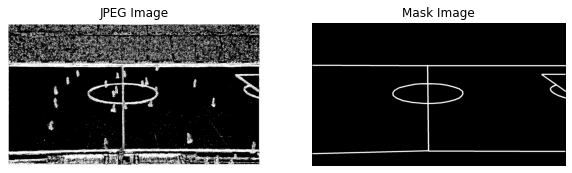

In [144]:
import random
import cv2
import matplotlib.pyplot as plt

image_number = random.randint(0, len(jpeg_images)-1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the JPEG image
axs[0].imshow(jpeg_images[image_number])
axs[0].set_title('JPEG Image')

# Plot the mask image
axs[1].imshow(mask_images[image_number])
axs[1].set_title('Mask Image')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Display the figure
plt.show()

In [145]:
def evaluate_masks(predicted_masks, ground_truth_masks):
    iou_scores = []
    dice_scores = []
    pixel_accuracy = []

    for i in range(len(predicted_masks)):
        pred_mask = predicted_masks[i]
        gt_mask = ground_truth_masks[i]
        intersection = np.logical_and(pred_mask, gt_mask)
        union = np.logical_or(pred_mask, gt_mask)

        iou = np.sum(intersection) / np.sum(union)
        dice = (2.0 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(gt_mask))
        accuracy = np.mean(pred_mask == gt_mask)

        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accuracy.append(accuracy)

    mean_iou = np.mean(iou_scores)
    mean_dice_scores = np.mean(dice_scores)
    mean_pixel_accuracy = np.mean(pixel_accuracy)

    print(f"Mean IoU: {mean_iou:.3f}")
    print(f"Mean Dice Scores: {mean_dice_scores:.3f}")
    print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.3f}")

In [146]:
def evaluate_masks_one(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)

    iou = np.sum(intersection) / np.sum(union)
    dice = (2.0 * np.sum(intersection)) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
    accuracy = np.mean(predicted_mask == ground_truth_mask)

    print(f"IoU: {iou:.3f}")
    print(f"Dice Score: {dice:.3f}")
    print(f"Pixel Accuracy: {accuracy:.3f}")


In [147]:
evaluate_masks_one(jpeg_images[0], mask_images[0])

IoU: 0.103
Dice Score: 0.001
Pixel Accuracy: 0.867


In [70]:
evaluate_masks(jpeg_images, mask_images)

Mean IoU: 0.085
Mean Dice Scores: 0.001
Mean Pixel Accuracy: 0.796


In [23]:
from sklearn.metrics import confusion_matrix

def compute_fpr_fnr_tpr_tnr(y_pred, ground_truth_masks):
    num_masks = len(y_pred)
    all_y_pred = np.concatenate(y_pred)
    all_ground_truth = np.concatenate(ground_truth_masks)

    cm = confusion_matrix(all_ground_truth.flatten(), all_y_pred.flatten())
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    print(f"False Positive Rate (FPR): {fpr:.3f}")
    print(f"False Negative Rate (FNR): {fnr:.3f}")

In [24]:
compute_fpr_fnr_tpr_tnr(jpeg_images, mask_images)

False Positive Rate (FPR): 0.003
False Negative Rate (FNR): 0.991
